# Fit and Test Decay-K ELO Model Against 538's ELO Model

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Read in Data
data538 = pd.read_csv('nba_elo.csv')

## Functions to Fit ELO

In [7]:
def get_post_elo(home_team, home_team_elo, away_team, away_team_elo, mov, decay):
    
    home_post_elo = get_k(mov, home_team_elo, away_team_elo, decay)*(int(mov>0) - get_win_prob(home_team_elo, away_team_elo)) + home_team_elo
    away_post_elo = away_team_elo + (home_team_elo - home_post_elo)
    
    return home_post_elo, away_post_elo
    
def get_win_prob(home_team_elo, away_team_elo):
    home_team_elo += 100
    return 1.0/(1.0+(10.0**((away_team_elo-home_team_elo)/400)))

def get_k(mov, team_elo, opp_elo, decay):
    
    if mov > 0: elo_dif = team_elo-opp_elo
    else: elo_dif = opp_elo-team_elo
    
    K = 20.0*((np.abs(mov)+3.0)**.8)
    K = K/(7.5 + .006*elo_dif)
    return K*decay

## Model Details:
 - Trained on 2010 - 2014 seasons
 - Validated on 2015 - 2016 seasons
 - Tested/Comppared to 538's Model on 2017 - 2018 seasons

In [8]:
# Get Just Seasons 2010 and on
games = data538[data538['season'] >= 2010]
games = games[games['season'] < 2019]

In [9]:
# Hyperparameters to Tune
season_start_epsilons = [.8, .9, .95, .98, 1.0, 1.02, 1.05, 1.1, 1.2]
epsilon_decays = [.6, .7, .8, .9, .95, .98, 1.0, 1.02, 1.05, 1.1, 1.2]

In [10]:
# Get Decay ELOs

VALIDATE_YEAR = 2015
TEST_YEAR = 2017

val_results_dict_list = []
test_results_dict_list = []

# For Each Combination of start_epsilon and epsilon_decay
for season_start_epsilon in season_start_epsilons:
    for epsilon_decay in epsilon_decays:
    
        epsilon = season_start_epsilon

        elo_dict = {}

        val_dict_list = []
        test_dict_list = []

        # For Each Game
        for i in range(games.shape[0]):

            # Get Game Info
            row = games.iloc[i]
            team = row.team1
            opp = row.team2
            mov = row.score1 - row.score2

            # Seasonal ELO Adjustment for Every Team
            if i > 0 and row.season != games.iloc[i-1].season:
                for k in elo_dict.keys():
                    elo_dict[k] = .75*elo_dict[k] + .25*1505
                    
                # Reset Epsilon
                epsilon = season_start_epsilon

            # If team's first game, use 538's elo to start
            if team not in elo_dict.keys():
                elo_dict[team] = row['elo1_pre']
            if opp not in elo_dict.keys():
                elo_dict[opp] = row['elo2_pre']

            # Get Pre-Game ELO Estimates
            team_pre = elo_dict[team]
            opp_pre = elo_dict[opp]

            # Adjust Epsilon Every 100 Games
            if i % 100 == 0:
                epsilon *= epsilon_decay

            # Update ELOs based on game results    
            elo_dict[team], elo_dict[opp] = get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon)

            # Model Validation
            if row.season >= VALIDATE_YEAR and row.season < TEST_YEAR:
                
                # Build DataFrame with Post-Game ELOs
                team_post = elo_dict[team]
                opp_post = elo_dict[opp]
                val_dict_list.append({'team1': team, 'team2': opp, 'team1_pre': team_pre, 'team2_pre': opp_pre, 'team1_post': team_post, 'team2_post': opp_post, 'MOV': mov})
            
        ########################
        # Validation DataFrame
        ########################
        '''Choose the best model based on the validation set'''
        
        val_df = pd.DataFrame(val_dict_list)
        
        preds = []
        losses = []
        outcomes = []
        
        # For Each Game in Validation Set
        for i in range(val_df.shape[0]):

            # Get Game Info
            row = val_df.iloc[i]
            mov = row.MOV 
            team_elo = row['team1_pre']
            opp_elo = row['team2_pre']

            # Get Predictions, Loss, and Results
            preds.append(get_win_prob(team_elo, opp_elo) > .5)
            losses.append(np.log(get_win_prob(team_elo, opp_elo) if mov > 0 else 1 - get_win_prob(team_elo, opp_elo)))
            outcomes.append(mov > 0)

        # True if Success, Otherwise False
        #success_list = [preds[j] == outcomes[j] for j in range(len(preds))]
        
        # Record Overall Loss
        
        
        # Make DataFrame of Validation Results
        #val_results_dict_list.append({'accuracy': np.mean(success_list), 'season_start_ep': season_start_epsilon, 'epsilon_decay': epsilon_decay})
        
        # Make DataFrame of Validation Results w/ Loss as accuracy
        val_results_dict_list.append({'accuracy': np.sum(losses), 'season_start_ep': season_start_epsilon, 'epsilon_decay': epsilon_decay})
        
val_results_df = pd.DataFrame(val_results_dict_list)

print('Best Validation Accuracy: ', np.max(val_results_df['accuracy']))
print('Best start_epsilon: ', val_results_df.loc[np.argmax(val_results_df['accuracy'])].season_start_ep)
print('Best epsilon_decay: ', val_results_df.loc[np.argmax(val_results_df['accuracy'])].epsilon_decay)

C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Best Validation Accuracy:  -1558.55904808
Best start_epsilon:  1.2
Best epsilon_decay:  0.95


C:\Users\ejohn\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [12]:
# Re-Fit Model w/ Best Validation Results
VALIDATE_YEAR = 2015
TEST_YEAR = 2017

test_results_dict_list = []

# Get Hyperparameters from Validated Model
season_start_epsilon = val_results_df.loc[np.argmax(val_results_df['accuracy'])].season_start_ep
epsilon_decay = val_results_df.loc[np.argmax(val_results_df['accuracy'])].epsilon_decay

######################
# Re-Fit Model
######################

epsilon = season_start_epsilon

elo_dict = {}

test_dict_list = []
all_dict_list = []

# For Each Game
for i in range(games.shape[0]):

    # Get Game Info
    row = games.iloc[i]
    team = row.team1
    opp = row.team2
    mov = row.score1 - row.score2

    # Seasonal ELO Adjustment for Every Team
    if i > 0 and row.season != games.iloc[i-1].season:
        for k in elo_dict.keys():
            elo_dict[k] = .75*elo_dict[k] + .25*1505

        # Reset Epsilon
        epsilon = season_start_epsilon

    # If team's first game, use 538's elo to start
    if team not in elo_dict.keys():
        elo_dict[team] = row['elo1_pre']
    if opp not in elo_dict.keys():
        elo_dict[opp] = row['elo2_pre']

    # Get Pre-Game ELO Estimates
    team_pre = elo_dict[team]
    opp_pre = elo_dict[opp]

    # Adjust Epsilon Every 100 Games
    if i % 100 == 0:
        epsilon *= epsilon_decay

    # Update ELOs based on game results    
    elo_dict[team], elo_dict[opp] = get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon)
    
    # Build DataFrame with new post-predictions
    team_post = elo_dict[team]
    opp_post = elo_dict[opp]

    all_dict_list.append({'date': row.date, 'season': row.season,
                          'team1': team, 'team2': opp, 'elo1_pre': team_pre, 'elo2_pre': opp_pre, 'elo1_post': team_post, 'elo2_post': opp_post,
                          'elo1_pre_538': row['elo1_pre'], 'elo2_pre_538': row['elo2_pre'],
                          'carm_elo1_pre_538': row['carm-elo1_pre'], 'carm_elo2_pre_538': row['carm-elo2_pre'],
                          'carmelo1_pre_538': row['carmelo1_pre'], 'carmelo2_pre_538': row['carmelo2_pre'],
                          'score1': row.score1, 'score2': row.score2,
                          'MOV': mov})

    # Final Model Testing
    if row.season >= TEST_YEAR:

        # Build DataFrame with new post-predictions
        team_post = elo_dict[team]
        opp_post = elo_dict[opp]

        test_dict_list.append({'team1': team, 'team2': opp, 'team1_pre': team_pre, 'team2_pre': opp_pre, 'team1_post': team_post, 'team2_post': opp_post, 'MOV': mov})

########################
# Test DataFrame
########################
'''Get Results on Test Set for Final Comparison'''

test_df= pd.DataFrame(test_dict_list)

preds = []
losses = []
outcomes = []

# For Each Game in Test Set
for i in range(test_df.shape[0]):

    # Get Game Info
    row = test_df.iloc[i]
    mov = row.MOV 
    team_elo = row['team1_pre']
    opp_elo = row['team2_pre']

    preds.append(get_win_prob(team_elo, opp_elo) > .5)
    losses.append(np.log(get_win_prob(team_elo, opp_elo) if mov > 0 else 1 - get_win_prob(team_elo, opp_elo)))
    outcomes.append(mov > 0)

# True if Success, Otherwise False
success_list = [preds[j] == outcomes[j] for j in range(len(preds))]

# Print Classification Accuracy
print('Loss of Chosen Model (on 2017 and 2018): ', np.sum(losses))
print('Loss of Chosen Model (on 2017 and 2018): ', np.mean(success_list))

C:\Users\ejohn\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


Loss of Chosen Model (on 2017 and 2018):  -1633.53216217
Loss of Chosen Model (on 2017 and 2018):  0.65623807707


## Write New .csv w/ new ELOs

In [13]:
pd.DataFrame(all_dict_list).to_csv('all_elos.csv')

## Get This Year's Predictions (as well as CARMELO's)
(Must be run directly after re-fitting)

--------------------
To update, just re-download .csv from fivethirtyeight's github and re-run everything

In [26]:
# Get Just 2018-2019 Season Games
games_2019 = data538[data538['season'] == 2019]
games_2019 = games_2019[~np.isnan(games_2019['score1'])]

In [27]:
# Adjust ELOs Back To Mean (For Change in Season)
for k in elo_dict.keys():
    elo_dict[k] = .75*elo_dict[k] + .25*1505

# Reset Epsilon
epsilon = season_start_epsilon

In [28]:
games_2019_dict_list = []

# For Each Game in 2019
for i in range(games_2019.shape[0]):

    # Get Game Info
    row = games.iloc[i]
    team = row.team1
    opp = row.team2
    mov = row.score1 - row.score2
    
    # Get Pre-Game ELO Estimates
    team_pre = elo_dict[team]
    opp_pre = elo_dict[opp]

    # Adjust Epsilon Every 100 Games
    if i % 100 == 0:
        epsilon *= epsilon_decay
        
    # Update ELOs based on game results    
    elo_dict[team], elo_dict[opp] = get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon)
    
    # Build DataFrame with new post-predictions
    team_post = elo_dict[team]
    opp_post = elo_dict[opp]

    games_2019_dict_list.append({'date': row.date, 'season': row.season,
                          'team1': team, 'team2': opp, 'elo1_pre': team_pre, 'elo2_pre': opp_pre, 'elo1_post': team_post, 'elo2_post': opp_post,
                          'elo1_pre_538': row['elo1_pre'], 'elo2_pre_538': row['elo2_pre'],
                          'carm_elo1_pre_538': row['carm-elo1_pre'], 'carm_elo2_pre_538': row['carm-elo2_pre'],
                          'carmelo1_pre_538': row['carmelo1_pre'], 'carmelo2_pre_538': row['carmelo2_pre'],
                          'score1': row.score1, 'score2': row.score2,
                          'MOV': mov})
    
pd.DataFrame(games_2019_dict_list).to_csv('2019_elos.csv')

# Fit Another Model, Further Tuning Shit

In [22]:
def get_post_elo(home_team, home_team_elo, away_team, away_team_elo, mov, decay, home_adv):
    
    home_post_elo = get_k(mov, home_team_elo, away_team_elo, decay)*(int(mov>0) - get_win_prob(home_team_elo, away_team_elo, home_adv)) + home_team_elo
    away_post_elo = away_team_elo + (home_team_elo - home_post_elo)
    
    return home_post_elo, away_post_elo
    
def get_win_prob(home_team_elo, away_team_elo, hfa):
    home_team_elo += hfa
    return 1.0/(1.0+(10.0**((away_team_elo-home_team_elo)/400)))

def get_k(mov, team_elo, opp_elo, decay):
    
    if mov > 0: elo_dif = team_elo-opp_elo
    else: elo_dif = opp_elo-team_elo
    
    K = 20.0*((np.abs(mov)+3.0)**.8)
    K = K/(7.5 + .006*elo_dif)
    return K*decay

In [23]:
# Get Just Seasons 2010 and on
games = data538[data538['season'] >= 2010]
games = games[games['season'] < 2019]

In [24]:
# Hyperparameters to Tune
season_start_epsilons = [.9, .95, .98, 1.0, 1.02, 1.05, 1.1, 1.15, 1.2, 1.3]
epsilon_decays = [.8, .9, .925, .95, .97, .98, 1.0, 1.02, 1.05, 1.1, 1.2]
hfas = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

In [25]:
# Get Decay ELOs

VALIDATE_YEAR = 2015
TEST_YEAR = 2017

val_results_dict_list = []
test_results_dict_list = []

# For Each Combination of start_epsilon and epsilon_decay
for season_start_epsilon in season_start_epsilons:
    for epsilon_decay in epsilon_decays:
        for h in hfas:

            epsilon = season_start_epsilon

            elo_dict = {}

            val_dict_list = []
            test_dict_list = []

            # For Each Game
            for i in range(games.shape[0]):

                # Get Game Info
                row = games.iloc[i]
                team = row.team1
                opp = row.team2
                mov = row.score1 - row.score2

                # Seasonal ELO Adjustment for Every Team
                if i > 0 and row.season != games.iloc[i-1].season:
                    for k in elo_dict.keys():
                        elo_dict[k] = .75*elo_dict[k] + .25*1505

                    # Reset Epsilon
                    epsilon = season_start_epsilon

                # If team's first game, use 538's elo to start
                if team not in elo_dict.keys():
                    elo_dict[team] = row['elo1_pre']
                if opp not in elo_dict.keys():
                    elo_dict[opp] = row['elo2_pre']

                # Get Pre-Game ELO Estimates
                team_pre = elo_dict[team]
                opp_pre = elo_dict[opp]

                # Adjust Epsilon Every 100 Games
                if i % 100 == 0:
                    epsilon *= epsilon_decay

                # Update ELOs based on game results    
                elo_dict[team], elo_dict[opp] = get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon, h)

                # Model Validation
                if row.season >= VALIDATE_YEAR and row.season < TEST_YEAR:

                    # Build DataFrame with Post-Game ELOs
                    team_post = elo_dict[team]
                    opp_post = elo_dict[opp]
                    val_dict_list.append({'team1': team, 'team2': opp, 'team1_pre': team_pre, 'team2_pre': opp_pre, 'team1_post': team_post, 'team2_post': opp_post, 'MOV': mov})

            ########################
            # Validation DataFrame
            ########################
            '''Choose the best model based on the validation set'''

            val_df = pd.DataFrame(val_dict_list)

            preds = []
            losses = []
            outcomes = []

            # For Each Game in Validation Set
            for i in range(val_df.shape[0]):

                # Get Game Info
                row = val_df.iloc[i]
                mov = row.MOV 
                team_elo = row['team1_pre']
                opp_elo = row['team2_pre']

                # Get Predictions, Loss, and Results
                preds.append(get_win_prob(team_elo, opp_elo, h) > .5)
                losses.append(np.log(get_win_prob(team_elo, opp_elo, h) if mov > 0 else 1 - get_win_prob(team_elo, opp_elo, h)))
                outcomes.append(mov > 0)

            # True if Success, Otherwise False
            #success_list = [preds[j] == outcomes[j] for j in range(len(preds))]

            # Record Overall Loss


            # Make DataFrame of Validation Results
            #val_results_dict_list.append({'accuracy': np.mean(success_list), 'season_start_ep': season_start_epsilon, 'epsilon_decay': epsilon_decay})

            # Make DataFrame of Validation Results w/ Loss as accuracy
            val_results_dict_list.append({'accuracy': np.sum(losses), 'season_start_ep': season_start_epsilon, 'epsilon_decay': epsilon_decay, 'HFA': h})
        
val_results_df = pd.DataFrame(val_results_dict_list)

print('Best Validation Accuracy: ', np.max(val_results_df['accuracy']))
print('Best start_epsilon: ', val_results_df.loc[np.argmax(val_results_df['accuracy'])].season_start_ep)
print('Best epsilon_decay: ', val_results_df.loc[np.argmax(val_results_df['accuracy'])].epsilon_decay)
print('Best epsilon_decay: ', val_results_df.loc[np.argmax(val_results_df['accuracy'])].HFA)

C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log
C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Best Validation Accuracy:  -1550.25198981
Best start_epsilon:  1.3
Best epsilon_decay:  0.95
Best epsilon_decay:  70.0


C:\Users\ejohn\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [26]:
# Re-Fit Model w/ Best Validation Results
VALIDATE_YEAR = 2015
TEST_YEAR = 2017

test_results_dict_list = []

# Get Hyperparameters from Validated Model
season_start_epsilon = val_results_df.loc[np.argmax(val_results_df['accuracy'])].season_start_ep
epsilon_decay = val_results_df.loc[np.argmax(val_results_df['accuracy'])].epsilon_decay
hfa = val_results_df.loc[np.argmax(val_results_df['accuracy'])].HFA

######################
# Re-Fit Model
######################

epsilon = season_start_epsilon

elo_dict = {}

test_dict_list = []
all_dict_list = []

# For Each Game
for i in range(games.shape[0]):

    # Get Game Info
    row = games.iloc[i]
    team = row.team1
    opp = row.team2
    mov = row.score1 - row.score2

    # Seasonal ELO Adjustment for Every Team
    if i > 0 and row.season != games.iloc[i-1].season:
        for k in elo_dict.keys():
            elo_dict[k] = .75*elo_dict[k] + .25*1505

        # Reset Epsilon
        epsilon = season_start_epsilon

    # If team's first game, use 538's elo to start
    if team not in elo_dict.keys():
        elo_dict[team] = row['elo1_pre']
    if opp not in elo_dict.keys():
        elo_dict[opp] = row['elo2_pre']

    # Get Pre-Game ELO Estimates
    team_pre = elo_dict[team]
    opp_pre = elo_dict[opp]

    # Adjust Epsilon Every 100 Games
    if i % 100 == 0:
        epsilon *= epsilon_decay

    # Update ELOs based on game results    
    elo_dict[team], elo_dict[opp] = get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon, hfa)
    
    # Build DataFrame with new post-predictions
    team_post = elo_dict[team]
    opp_post = elo_dict[opp]

    all_dict_list.append({'date': row.date, 'season': row.season,
                          'team1': team, 'team2': opp, 'elo1_pre': team_pre, 'elo2_pre': opp_pre, 'elo1_post': team_post, 'elo2_post': opp_post,
                          'elo1_pre_538': row['elo1_pre'], 'elo2_pre_538': row['elo2_pre'],
                          'carm_elo1_pre_538': row['carm-elo1_pre'], 'carm_elo2_pre_538': row['carm-elo2_pre'],
                          'carmelo1_pre_538': row['carmelo1_pre'], 'carmelo2_pre_538': row['carmelo2_pre'],
                          'score1': row.score1, 'score2': row.score2,
                          'MOV': mov})

    # Final Model Testing
    if row.season >= TEST_YEAR:

        # Build DataFrame with new post-predictions
        team_post = elo_dict[team]
        opp_post = elo_dict[opp]

        test_dict_list.append({'team1': team, 'team2': opp, 'team1_pre': team_pre, 'team2_pre': opp_pre, 'team1_post': team_post, 'team2_post': opp_post, 'MOV': mov})

########################
# Test DataFrame
########################
'''Get Results on Test Set for Final Comparison'''

test_df= pd.DataFrame(test_dict_list)

preds = []
losses = []
outcomes = []

# For Each Game in Test Set
for i in range(test_df.shape[0]):

    # Get Game Info
    row = test_df.iloc[i]
    mov = row.MOV 
    team_elo = row['team1_pre']
    opp_elo = row['team2_pre']

    preds.append(get_win_prob(team_elo, opp_elo, hfa) > .5)
    losses.append(np.log(get_win_prob(team_elo, opp_elo, hfa) if mov > 0 else 1 - get_win_prob(team_elo, opp_elo, hfa)))
    outcomes.append(mov > 0)

# True if Success, Otherwise False
success_list = [preds[j] == outcomes[j] for j in range(len(preds))]

# Print Classification Accuracy
print('Loss of Chosen Model (on 2017 and 2018): ', np.sum(losses))
print('Accuracy of Chosen Model (on 2017 and 2018): ', np.mean(success_list))

C:\Users\ejohn\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


Loss of Chosen Model (on 2017 and 2018):  -1625.47654702
Accuracy of Chosen Model (on 2017 and 2018):  0.655475009538


In [28]:
val_results_df.shape

(1430, 4)

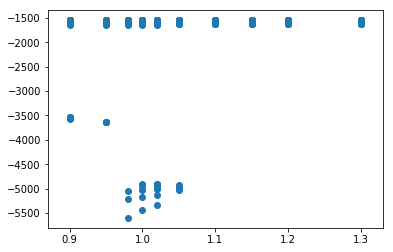

In [32]:
plt.scatter(val_results_df['season_start_ep'], val_results_df['accuracy'])
plt.show()